In this notebook, we will implement another neural network using the popular machine learning package for neural networks and deep learning, [Keras](https://keras.io) which is built on top of [tensorflow](https://www.tensorflow.org).   

We work with the [Handwritten Digits Data Sets](http://scikit-learn.org/stable/datasets/#optical-recognition-of-handwritten-digits-data-set) again to classify the digits using a Multilayer Perceptron (MLP). 

In [1]:
# import all the needed module
import numpy as np
import itertools
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,confusion_matrix

## Load and visualize data 

Just like in the last notebook, let's load the [Handwritten Digits Data Set](http://yann.lecun.com/exdb/mnist/) but from Keras this time. Once again, the dataset contains images of the 10 classes of handwritten digits (0 to 9). The data includes a training set of 60,000 examples, and a test set of 10,000 examples which is a subset of a larger set available from NIST.  

In [2]:
# load the data which is already split for us as a train and test set
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
print(f'The dataset contains {len(x_train)} training data examples, and {len(x_test)} test data examples')

The dataset contains 60000 training data examples, and 10000 test data examples


In [4]:
# The unique classes
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of anti-aliasing (a technique to minimize distortion when compressing an image). The images were also centered in a 28x28 image by computing the center of mass of the pixels.

In [5]:
# let's look at one sample in our training data
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [6]:
# the first 10 labels/classes of the training data
print(y_train[0:10])

[5 0 4 1 9 2 1 3 1 4]


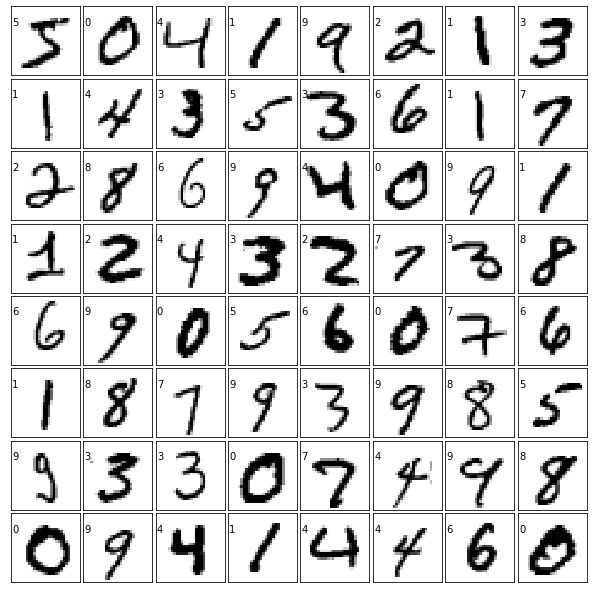

In [7]:
## plot the first 64 samples, and get a sense of the data
fig = plt.figure(figsize = (8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(64):
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
    ax.imshow(x_train[i],cmap=plt.cm.binary,interpolation='nearest')
    ax.text(0, 7, str(y_train[i]))

## Prepare data for ANN

In [14]:
# Flatten the images into 1D arrays
# Each image is currently a matrix with 28 rows and 28 columns, we can reshape this into a vector with (28x28) = 784 elements
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

# Convert the data type from int to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize the data by dividing the maximum value
x_train /= 255
x_test /= 255

In [15]:
num_classes = 10
# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [16]:
# See what the labeling look like now by printing out the first label
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

## Build ANN classifier  

Let's start to build the ANN model. We start by initializing a sequential model and add two hidden layers. 

In [17]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


Notice that we are adding and changing a few components of our MLP architecture.     
1. `model.add(Dropout(0.2))` - Prevents our neural network from overfitting the data by ignoring (dropping) a random subset of neuron updates during backpropogation.     
2. `activation = 'relu'` - We are now using the rectified linear activation unit (ReLU) which is more less computationally burdensome than the sigmoid.     
3. `activation = 'softmax'` - A generalization of the sigmoid function returns a probability between 0-1 for all our classes and returns the maximum value.

In [18]:
# We compile the model by telling it what algorithms we are using for the backprop. 
# what metrics to mesure and so on. 
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

During compiling we specify a few things.
1. `loss='categorical_crossentropy'` - Define our loss function as cross entropy.
2. `optimizer=RMSprop()` - Define our weight update optimizer as RMSprop (Root Mean Square Propogation).
3. `metrics=['accuracy']` - Define our metrics to be displayed during model training. (This is for your own evaluation!)

## Train the model

Let's train the model using a batch size 128 and 20 epochs. 

In [19]:
batch_size = 128
epochs = 20

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

2021-07-30 17:37:15.419611: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
469/469 [==============================] - 12s 25ms/step - loss: 0.2471 - accuracy: 0.9245 - val_loss: 0.1032 - val_accuracy: 0.9668
Epoch 2/20
469/469 [==============================] - 13s 28ms/step - loss: 0.1013 - accuracy: 0.9693 - val_loss: 0.0913 - val_accuracy: 0.9725
Epoch 3/20
469/469 [==============================] - 14s 29ms/step - loss: 0.0744 - accuracy: 0.9771 - val_loss: 0.0834 - val_accuracy: 0.9753
Epoch 4/20
469/469 [==============================] - 14s 29ms/step - loss: 0.0599 - accuracy: 0.9816 - val_loss: 0.0687 - val_accuracy: 0.9812
Epoch 5/20
469/469 [==============================] - 14s 29ms/step - loss: 0.0506 - accuracy: 0.9848 - val_loss: 0.0759 - val_accuracy: 0.9807
Epoch 6/20
469/469 [==============================] - 14s 29ms/step - loss: 0.0422 - accuracy: 0.9871 - val_loss: 0.0730 - val_accuracy: 0.9811
Epoch 7/20
469/469 [==============================] - 14s 30ms/step - loss: 0.0381 - accuracy: 0.9888 - val_loss: 0.0798 - val_accuracy:

We are adding some additional arguments to our training process including:
1. ` batch_size = 128 ` - The number of data samples we pass to the model each time we use to update the weights.
2. ` epochs = 20 ` - The number of iterations use on the entire dataset. We are using 20 here, which means we run the training 20 times on all the training data. 

## Test ANN classifier and evaluate  

After we trained the ANN classifier, we will test the performance of the classifier using the test data.

In [20]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.13040286302566528
Test accuracy: 0.9829999804496765


## Visualize the test results

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure(figsize=(8, 8)) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

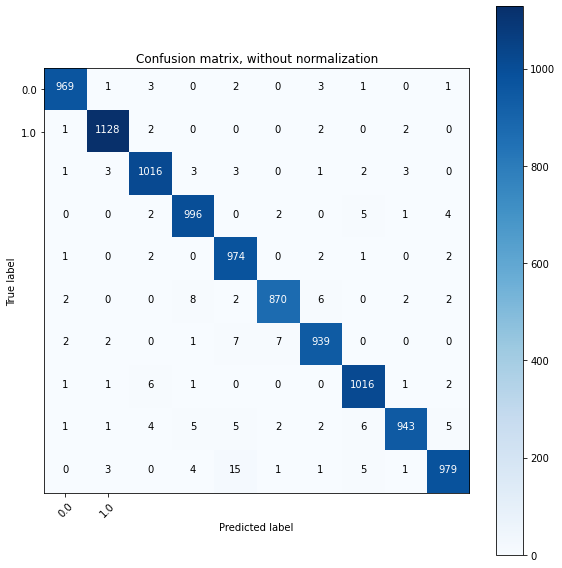

In [22]:
# predict results from the test data
predicted = model.predict(x_test)
predicted = np.argmax(predicted, axis=1)

# plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis =1),predicted)

plot_confusion_matrix(cm, classes=np.unique(y_test),
                      title='Confusion matrix, without normalization')

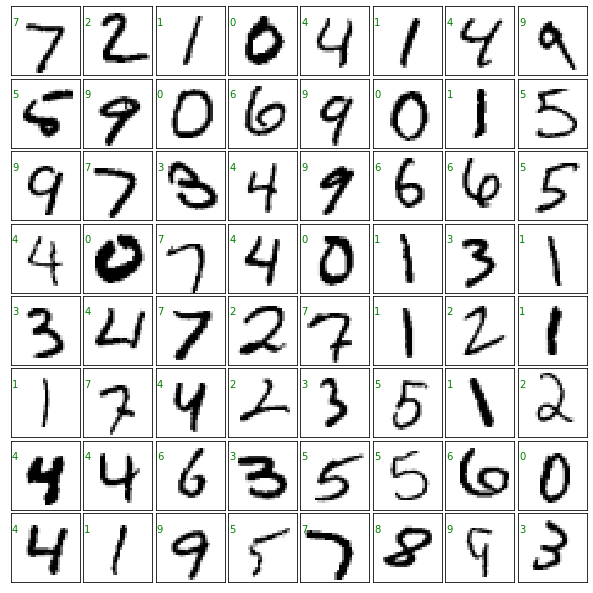

In [23]:
expected = np.argmax(y_test, axis =1) 
fig = plt.figure(figsize=(8, 8))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test.reshape(-1, 28, 28)[i], cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    if predicted[i] == expected[i]:
        ax.text(0, 7, str(predicted[i]), color='green')
    else:
        ax.text(0, 7, str(predicted[i]), color='red')